In [49]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from functools import reduce


In [90]:
# --- Image Loading ---
def load_model(model_path: str) -> YOLO:
    return YOLO(model_path)

def load_image(image_path: str) -> np.ndarray:
    image_path_obj = Path(image_path)
    img = cv2.imread(str(image_path_obj))
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path_obj}")
    return img

# --- Basic Image Processing ---
def sharpen_image(img: np.ndarray) -> np.ndarray:
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def equalize_histogram(img: np.ndarray) -> np.ndarray:
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y_eq = cv2.equalizeHist(y)
    ycrcb_eq = cv2.merge([y_eq, cr, cb])
    return cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)

def to_grayscale(img: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# --- Skew Detection (PCA) ---
def detect_skew_pca(gray: np.ndarray, debug: bool = False) -> float:
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0.0
    cnt = max(contours, key=cv2.contourArea)
    data_pts = np.array(cnt, dtype=np.float64).reshape(-1, 2)
    mean, eigenvectors = cv2.PCACompute(data_pts, mean=None)
    
    # Tính góc trong không gian radian
    angle = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])



    if debug:
        draw_debug_pca(gray, mean, eigenvectors, angle)

    # Trả về góc dưới dạng độ
    return np.degrees(angle)


# --- Skew Detection (Hough) ---
def detect_skew_hough(gray: np.ndarray, visualize: bool = False): 
    limit=45
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 10)   
    edges = cv2.Canny(binary, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 150)

    angles = []
    if lines is not None:
        for rho, theta in lines[:, 0]:
            deg = np.rad2deg(theta)
            if deg < limit or deg > (180 - limit):  # Chỉ lấy gần ngang
                angles.append(theta)

    if angles:
        median_angle = np.median(angles)
        skew_deg = np.rad2deg(median_angle) - 90
    else:
        median_angle = 0.0
        skew_deg = 0.0

    if visualize:
        vis_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        for rho, theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(vis_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
        return skew_deg, vis_img, edges

    return skew_deg, None, edges

def detect_skew_combined(gray: np.ndarray, visualize: bool = False):
    hough_angle, hough_vis, binary = detect_skew_hough(gray, visualize=visualize)
    pca_angle = detect_skew_pca(gray, debug=visualize)
    angle = 0.9 * pca_angle + 0.1 * hough_angle
    return (pca_angle, hough_vis, binary) if visualize else pca_angle


# --- Debug Drawing ---
def draw_debug_pca(gray: np.ndarray, mean: np.ndarray, eigenvectors: np.ndarray, angle: float):
    debug_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    center = tuple(mean[0].astype(int))
    endpoint = (int(center[0] + 100 * eigenvectors[0, 0]), int(center[1] + 100 * eigenvectors[0, 1]))
    cv2.line(debug_img, center, endpoint, (0, 255, 0), 2)
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected angle: {np.degrees(angle):.2f} degrees")
    plt.axis("off")
    plt.show()

# --- Image Rotation ---
def rotate_image_bound(img: np.ndarray, angle: float, mode: str = "inpaint") -> np.ndarray:
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = abs(M[0, 0])
    sin = abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    if mode == "transparent":
        if img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
        return cv2.warpAffine(img, M, (nW, nH), flags=cv2.INTER_LINEAR,
                              borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))
    elif mode == "interpolate":
        return cv2.warpAffine(img, M, (nW, nH), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    else:
        return cv2.warpAffine(img, M, (nW, nH), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

# --- Pipeline Steps ---
def correct_skew(img: np.ndarray, debug: bool = False, mode: str = "inpaint") -> np.ndarray:
    gray = img if len(img.shape) == 2 else to_grayscale(img)
    if debug:
        angle, vis, _ = detect_skew_combined(gray, visualize=True)
        print(f"Detected skew angle: {angle:.2f} degrees")  # Log the skew angle
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.title(f"Combined Skew Detection Visualization\nAngle: {angle:.2f} degrees")
        plt.axis("off")
        plt.show()
    else:
        angle = detect_skew_combined(gray)
    return rotate_image_bound(img, angle, mode)

def preprocess_image(img: np.ndarray, debug: bool = False) -> np.ndarray:
    gray = to_grayscale(img)
    gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    gray_bgr = equalize_histogram(gray_bgr)
    gray_bgr = sharpen_image(gray_bgr)
    img_corrected = correct_skew(gray_bgr, debug)
    return to_grayscale(img_corrected)

# --- Inference and Plotting ---
def run_inference(model: YOLO, img: np.ndarray):
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return model(img)


def plot_results(results):
    result_img = results[0].plot()
    plt.figure(figsize=(12, 8))
    plt.imshow(result_img)
    plt.axis("off")
    plt.show()

# --- Function Composition ---
def compose(*functions):
    return lambda x: reduce(lambda v, f: f(v), functions, x)

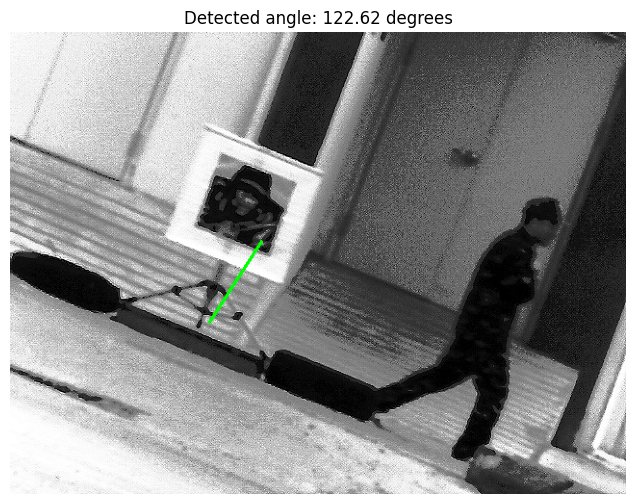

Detected skew angle: 122.62 degrees


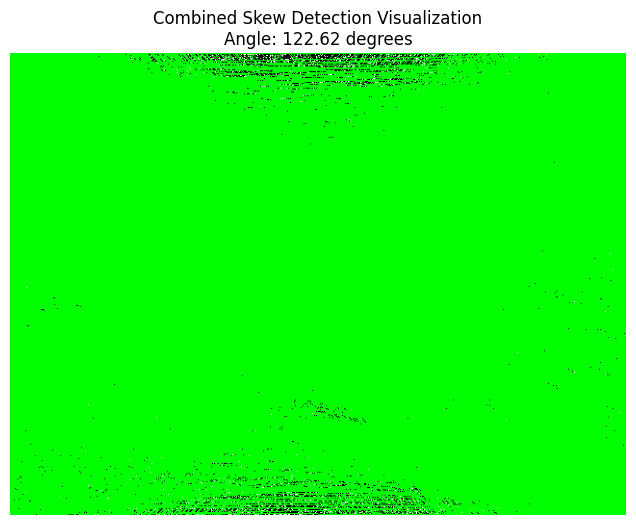


0: 640x608 2 bias, 812.5ms
Speed: 3.9ms preprocess, 812.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


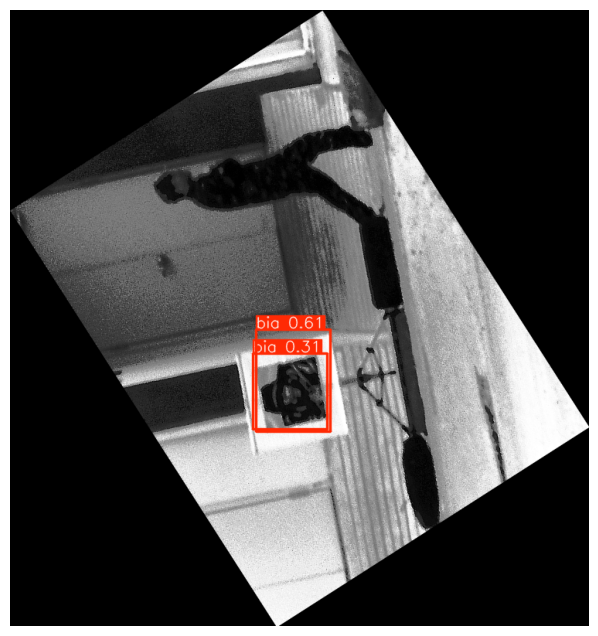

: 

In [ ]:
if __name__ == "__main__":
    model_path = "yolo-models/yolo11x_bia-4.01.pt"
    image_path = "images/bo du lieu bia so 4/bia4 (3).bmp"

    model = load_model(model_path)
    img = load_image(image_path)
    preprocessed_img = preprocess_image(img, debug=True)
    results = run_inference(model, preprocessed_img)
    plot_results(results)

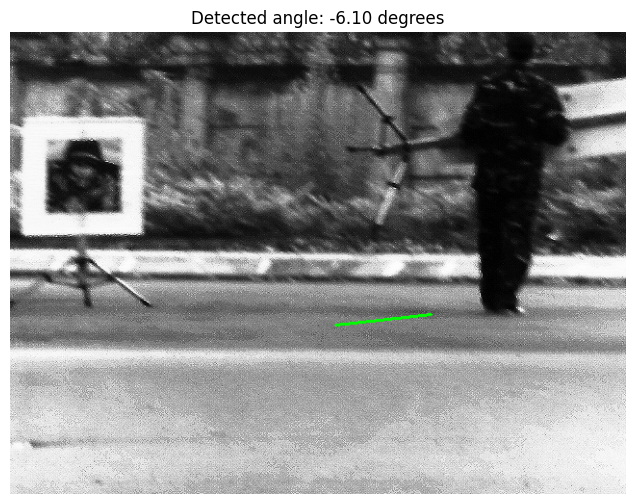


0: 512x640 2 bias, 715.1ms
Speed: 1.9ms preprocess, 715.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


In [56]:
if __name__ == "__main__":
    model_path = "yolo-models/yolo11x_bia-4.00.pt"
    image_path = "images/bo du lieu bia so 4/bia4 (12).bmp"

    model = load_model(model_path)
    img = load_image(image_path)
    preprocessed_img = preprocess_image(img, debug=True)
    results = run_inference(model, preprocessed_img)

In [ ]:
model_path='yolo-models/yolo11n-obb.pt'

model = YOLO(model_path)
res = model.predict(source=image)[0]
if len(res.obb.xywhr)==0: return image
x,y,w,h,angle = res.obb.xywhr[0]
M = cv2.getRotationMatrix2D((image.shape[1]/2,image.shape[0]/2), angle,1.0)
    return cv2.warpAffine(image, M, (image.shape[1],image.shape[0]))